<a href="https://colab.research.google.com/github/zinebelouardi/Generative-AI/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating Images of Clothes Using Deep Convolutional Generative Adversarial Network (DCGAN)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.27MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 173kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.31MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.4MB/s]


[1/50] D_loss: 0.3855 | G_loss: 1.2548
[2/50] D_loss: 0.5207 | G_loss: 1.1894
[3/50] D_loss: 0.5826 | G_loss: 1.0664
[4/50] D_loss: 0.5873 | G_loss: 0.8347
[5/50] D_loss: 0.5725 | G_loss: 1.3465
[6/50] D_loss: 0.4906 | G_loss: 1.2973
[7/50] D_loss: 0.6203 | G_loss: 1.0497
[8/50] D_loss: 0.7034 | G_loss: 0.7649
[9/50] D_loss: 0.6571 | G_loss: 1.0215
[10/50] D_loss: 0.6095 | G_loss: 1.0207
[11/50] D_loss: 0.6627 | G_loss: 0.8005
[12/50] D_loss: 0.7136 | G_loss: 0.7169
[13/50] D_loss: 0.6200 | G_loss: 1.1315
[14/50] D_loss: 0.6359 | G_loss: 0.7005
[15/50] D_loss: 0.6032 | G_loss: 0.8342
[16/50] D_loss: 0.6454 | G_loss: 0.7742
[17/50] D_loss: 0.6249 | G_loss: 0.8160
[18/50] D_loss: 0.6068 | G_loss: 0.8842
[19/50] D_loss: 0.6430 | G_loss: 0.9721
[20/50] D_loss: 0.6738 | G_loss: 1.0002
[21/50] D_loss: 0.6661 | G_loss: 0.7705
[22/50] D_loss: 0.6770 | G_loss: 0.7569
[23/50] D_loss: 0.6683 | G_loss: 0.8449
[24/50] D_loss: 0.7209 | G_loss: 0.6204
[25/50] D_loss: 0.6323 | G_loss: 0.9220
[26/50] D

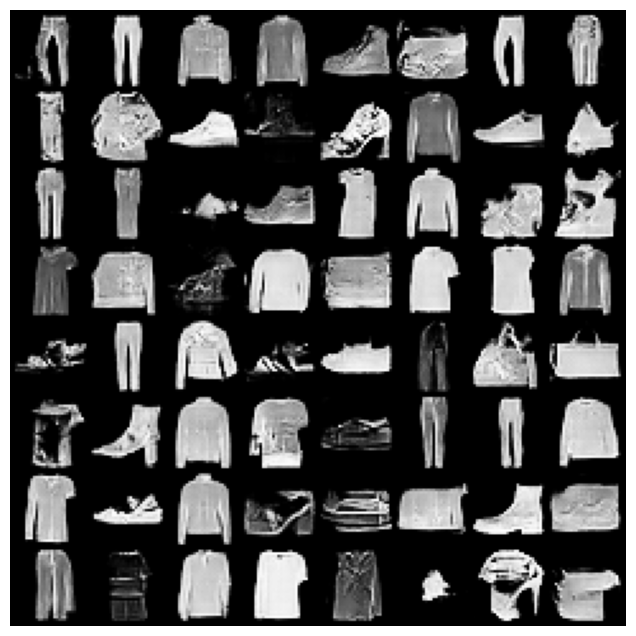

In [ ]:
# Copie propre et améliorée du DCGAN sur Fashion-MNIST
# ================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import os

# ====================
# 1. Paramètres
# ====================
batch_size = 128
lr = 0.0002
latent_dim = 100
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====================
# 2. Dataset
# ====================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # images dans [-1, 1]
])

dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ====================
# 3. Modèles
# ====================
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 7, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1).squeeze(1)

# ====================
# 4. Initialisation
# ====================
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# ====================
# 5. Entraînement
# ====================
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Vrai et faux labels
        valid = torch.ones(batch_size, device=device)
        fake = torch.zeros(batch_size, device=device)

        # ---- Entraînement Discriminateur ----
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = G(z).detach()

        real_loss = criterion(D(real_imgs), valid)
        fake_loss = criterion(D(fake_imgs), fake)
        D_loss = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # ---- Entraînement Générateur ----
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        gen_imgs = G(z)
        G_loss = criterion(D(gen_imgs), valid)

        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

    print(f"[{epoch+1}/{epochs}] D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}")

    # Sauvegarde images toutes les 10 époques
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            fake = G(fixed_noise).detach().cpu()
        grid = make_grid(fake, nrow=8, normalize=True)
        save_image(grid, f"fashion_epoch_{epoch+1}.png")

# ====================
# 6. Affichage résultat
# ====================
fake = G(fixed_noise).detach().cpu()
grid = make_grid(fake, nrow=8, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()


# Generating Images of Clothes Using a Conditional Deep Convolutional Generative Adversarial Network (cDCGAN)

Epoch 1/50: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]


[Epoch 1/50] D_loss: 0.6053 | G_loss: 1.5922


Epoch 2/50: 100%|██████████| 469/469 [00:21<00:00, 21.56it/s]


[Epoch 2/50] D_loss: 0.6294 | G_loss: 1.0409


Epoch 3/50: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]


[Epoch 3/50] D_loss: 0.7070 | G_loss: 1.0485


Epoch 4/50: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]


[Epoch 4/50] D_loss: 0.6614 | G_loss: 0.7688


Epoch 5/50: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]


[Epoch 5/50] D_loss: 0.6874 | G_loss: 0.8419


Epoch 6/50: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]


[Epoch 6/50] D_loss: 0.6615 | G_loss: 1.0010


Epoch 7/50: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]


[Epoch 7/50] D_loss: 0.7410 | G_loss: 0.8552


Epoch 8/50: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]


[Epoch 8/50] D_loss: 0.6452 | G_loss: 1.0480


Epoch 9/50: 100%|██████████| 469/469 [00:21<00:00, 22.07it/s]


[Epoch 9/50] D_loss: 0.6698 | G_loss: 0.8090


Epoch 10/50: 100%|██████████| 469/469 [00:21<00:00, 22.05it/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 10/50] D_loss: 0.7029 | G_loss: 0.8974
FID: 0.6908


Epoch 11/50: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]


[Epoch 11/50] D_loss: 0.6879 | G_loss: 0.8364


Epoch 12/50: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]


[Epoch 12/50] D_loss: 0.7154 | G_loss: 0.9195


Epoch 13/50: 100%|██████████| 469/469 [00:21<00:00, 22.04it/s]


[Epoch 13/50] D_loss: 0.6953 | G_loss: 0.6822


Epoch 14/50: 100%|██████████| 469/469 [00:21<00:00, 22.05it/s]


[Epoch 14/50] D_loss: 0.6733 | G_loss: 0.7552


Epoch 15/50: 100%|██████████| 469/469 [00:21<00:00, 22.07it/s]


[Epoch 15/50] D_loss: 0.6949 | G_loss: 0.8061


Epoch 16/50: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]


[Epoch 16/50] D_loss: 0.6914 | G_loss: 0.8393


Epoch 17/50: 100%|██████████| 469/469 [00:21<00:00, 22.04it/s]


[Epoch 17/50] D_loss: 0.7072 | G_loss: 0.7797


Epoch 18/50: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]


[Epoch 18/50] D_loss: 0.6996 | G_loss: 0.8179


Epoch 19/50: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]


[Epoch 19/50] D_loss: 0.7039 | G_loss: 0.7673


Epoch 20/50: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]


[Epoch 20/50] D_loss: 0.7012 | G_loss: 0.7575
FID: 1.1707


Epoch 21/50: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]


[Epoch 21/50] D_loss: 0.6941 | G_loss: 0.8837


Epoch 22/50: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]


[Epoch 22/50] D_loss: 0.7209 | G_loss: 0.8085


Epoch 23/50: 100%|██████████| 469/469 [00:21<00:00, 21.98it/s]


[Epoch 23/50] D_loss: 0.7084 | G_loss: 0.8294


Epoch 24/50: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]


[Epoch 24/50] D_loss: 0.6917 | G_loss: 0.8114


Epoch 25/50: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]


[Epoch 25/50] D_loss: 0.7197 | G_loss: 0.8135


Epoch 26/50: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]


[Epoch 26/50] D_loss: 0.7015 | G_loss: 0.7940


Epoch 27/50: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]


[Epoch 27/50] D_loss: 0.6998 | G_loss: 0.8204


Epoch 28/50: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]


[Epoch 28/50] D_loss: 0.6885 | G_loss: 0.8343


Epoch 29/50: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]


[Epoch 29/50] D_loss: 0.7057 | G_loss: 0.7963


Epoch 30/50: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]


[Epoch 30/50] D_loss: 0.6971 | G_loss: 0.7812
FID: 1.0334


Epoch 31/50: 100%|██████████| 469/469 [00:21<00:00, 22.12it/s]


[Epoch 31/50] D_loss: 0.7072 | G_loss: 0.7798


Epoch 32/50: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]


[Epoch 32/50] D_loss: 0.7027 | G_loss: 0.7929


Epoch 33/50: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]


[Epoch 33/50] D_loss: 0.6892 | G_loss: 0.8189


Epoch 34/50: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]


[Epoch 34/50] D_loss: 0.6913 | G_loss: 0.7498


Epoch 35/50: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]


[Epoch 35/50] D_loss: 0.6652 | G_loss: 0.7585


Epoch 36/50: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]


[Epoch 36/50] D_loss: 0.7025 | G_loss: 0.7620


Epoch 37/50: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]


[Epoch 37/50] D_loss: 0.6881 | G_loss: 0.8071


Epoch 38/50: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]


[Epoch 38/50] D_loss: 0.6898 | G_loss: 0.7583


Epoch 39/50: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]


[Epoch 39/50] D_loss: 0.7047 | G_loss: 0.7686


Epoch 40/50: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]


[Epoch 40/50] D_loss: 0.6783 | G_loss: 0.8139
FID: 0.6300


Epoch 41/50: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]


[Epoch 41/50] D_loss: 0.6979 | G_loss: 0.7795


Epoch 42/50: 100%|██████████| 469/469 [00:21<00:00, 22.27it/s]


[Epoch 42/50] D_loss: 0.6847 | G_loss: 0.7952


Epoch 43/50: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]


[Epoch 43/50] D_loss: 0.6956 | G_loss: 0.7863


Epoch 44/50: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]


[Epoch 44/50] D_loss: 0.6879 | G_loss: 0.7728


Epoch 45/50: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]


[Epoch 45/50] D_loss: 0.6906 | G_loss: 0.8024


Epoch 46/50: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]


[Epoch 46/50] D_loss: 0.6921 | G_loss: 0.8059


Epoch 47/50: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]


[Epoch 47/50] D_loss: 0.6952 | G_loss: 0.8322


Epoch 48/50: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]


[Epoch 48/50] D_loss: 0.6885 | G_loss: 0.7492


Epoch 49/50: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]


[Epoch 49/50] D_loss: 0.6916 | G_loss: 0.7658


Epoch 50/50: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]


[Epoch 50/50] D_loss: 0.6724 | G_loss: 0.7661
FID: 1.4062


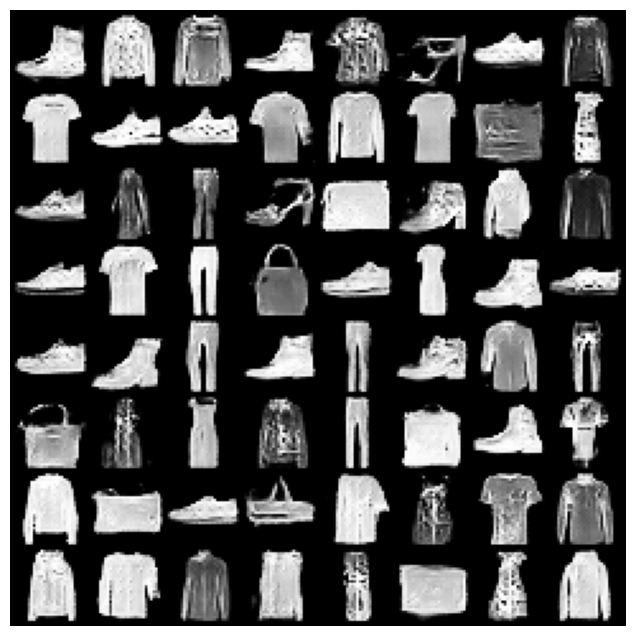

Entraînement terminé ! Les images sont dans /content/generated_images et les checkpoints sauvegardés.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy import linalg
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import inception_v3
import os

# ================================================
#  DCGAN Conditionnel (cGAN) + FID – Version Colab
# ================================================
# Compatible Google Colab : inclut les installs, montage Google Drive,
# et sauvegarde automatique des images et checkpoints.

# ====================
# 1. Préparation Colab
# ====================
!pip install torch torchvision tqdm scipy tensorboard --quiet
!mkdir -p /content/generated_images
!mkdir -p /content/checkpoints

from google.colab import drive

#  Monte ton Google Drive si tu veux sauvegarder les résultats
# drive.mount('/content/drive')
# os.makedirs('/content/drive/MyDrive/DCGAN_FashionMNIST', exist_ok=True)


# ====================
# 2. Paramètres
# ====================
latent_dim = 100
num_classes = 10
img_size = 28
channels = 1
batch_size = 128
epochs = 50
lr = 0.0002
betas = (0.5, 0.999)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====================
# 3. Dataset
# ====================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ====================
# 4. Modèles (cGAN)
# ====================
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + num_classes, 256, 7, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Unsqueeze labels to match spatial dimensions of noise for concatenation
        # label_emb output shape is (batch_size, num_classes)
        # after unsqueeze(2).unsqueeze(3), it becomes (batch_size, num_classes, 1, 1)
        gen_input = torch.cat((noise, self.label_emb(labels).unsqueeze(2).unsqueeze(3)), dim=1)
        return self.model(gen_input)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        # Add a linear layer to project the num_classes embedding to a single channel
        self.embedding_to_channel = nn.Linear(num_classes, 1)
        self.model = nn.Sequential(
            nn.Conv2d(1 + 1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Get the label embedding (batch_size, num_classes)
        embedded_labels = self.label_emb(labels)
        # Project the embedding to a single channel (batch_size, 1)
        single_channel_label = self.embedding_to_channel(embedded_labels)
        # Reshape to (batch_size, 1, 1, 1) and then expand spatially
        label_map = single_channel_label.unsqueeze(2).unsqueeze(3).expand(-1, -1, img_size, img_size)
        d_in = torch.cat((img, label_map), dim=1)
        return self.model(d_in).view(-1, 1).squeeze(1)

# ====================
# 5. Initialisation
# ====================
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=betas)
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=betas)

writer = SummaryWriter()

# ====================
# 6. Fonction FID
# ====================
def calculate_fid(real_images, fake_images):
    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.fc = nn.Identity()
    inception.eval()

    # Resize images to InceptionV3 expected input size (299x299)
    resize_transform = transforms.Compose([
        transforms.Resize(299),
        transforms.Normalize([0.5], [0.5]) # Already normalized to [-1, 1] but inception expects 0-1 and then normalized. Let's keep it simple for now
    ])

    def get_activations(images):
        # InceptionV3 expects 3-channel images, repeat grayscale channel
        images = images.repeat(1, 3, 1, 1)
        # Resize to 299x299
        images = transforms.Resize(299)(images) # Apply Resize directly
        with torch.no_grad():
            act = inception(images)[0].view(images.size(0), -1)
        return act

    act1 = get_activations(real_images)
    act2 = get_activations(fake_images)

    mu1, sigma1 = act1.mean(0), torch.cov(act1.T)
    mu2, sigma2 = act2.mean(0), torch.cov(act2.T)

    diff = mu1 - mu2
    covmean = torch.from_numpy(linalg.sqrtm((sigma1 @ sigma2).cpu().numpy()).real).to(device)
    fid = diff.dot(diff) + torch.trace(sigma1 + sigma2 - 2 * covmean)
    return fid.item()

# ====================
# 7. Entraînement
# ====================
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)
fixed_labels = torch.randint(0, num_classes, (64,), device=device)

for epoch in range(epochs):
    for imgs, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.size(0)

        valid = torch.ones(batch_size, device=device) * 0.9
        fake = torch.zeros(batch_size, device=device)

        # ----- Train Discriminator -----
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)
        fake_imgs = G(z, gen_labels).detach()

        real_loss = criterion(D(imgs, labels), valid)
        fake_loss = criterion(D(fake_imgs, gen_labels), fake)
        D_loss = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # ----- Train Generator -----
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)
        gen_imgs = G(z, gen_labels)

        G_loss = criterion(D(gen_imgs, gen_labels), valid)
        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

    # ----- Logging -----
    print(f"[Epoch {epoch+1}/{epochs}] D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}")

    writer.add_scalar('Loss/Discriminator', D_loss.item(), epoch)
    writer.add_scalar('Loss/Generator', G_loss.item(), epoch)

    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            fake = G(fixed_noise, fixed_labels).detach().cpu()
        grid = make_grid(fake, nrow=8, normalize=True)
        save_image(grid, f"/content/generated_images/fashion_epoch_{epoch+1}.png")

        real_batch = next(iter(dataloader))[0][:len(fake)].to(device)
        fid = calculate_fid(real_batch, fake.to(device))
        writer.add_scalar('FID', fid, epoch)
        print(f"FID: {fid:.4f}")

        torch.save({
            'epoch': epoch,
            'G_state_dict': G.state_dict(),
            'D_state_dict': D.state_dict(),
            'optimizer_G': optimizer_G.state_dict(),
            'optimizer_D': optimizer_D.state_dict(),
        }, f"/content/checkpoints/checkpoint_epoch_{epoch+1}.pth")

# ====================
# 8. Visualisation finale
# ====================
with torch.no_grad():
    fake = G(fixed_noise, fixed_labels).detach().cpu()

plt.figure(figsize=(8,8))
plt.imshow(make_grid(fake, nrow=8, normalize=True).permute(1, 2, 0))
plt.axis('off')
plt.show()

print("Entraînement terminé ! Les images sont dans /content/generated_images et les checkpoints sauvegardés.")

## Experiment overview

In this experiment we will generate images of clothing using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) training loop. For training we will be using Fashion [MNIST dataset](https://www.tensorflow.org/datasets/catalog/fashion_mnist).

A **generative adversarial network** (GAN) is a class of machine learning frameworks. Two neural networks contest with each other in a game. Two models are trained simultaneously by an adversarial process. A generator ("the artist") learns to create images that look real, while a discriminator ("the art critic") learns to tell real images apart from fakes.

![clothes_generation_dcgan.jpg](https://github.com/trekhleb/machine-learning-experiments/blob/master/demos/src/images/clothes_generation_dcgan.jpg?raw=1)